In [1]:
# show how sentiment changes over time with the audio

# imports
from transformers import pipeline
from text_stop_sentences import text_stop_sentences
from tgs_manual import get_tgs_manual
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from os import listdir
from os.path import isfile, join
import nltk
import json
import mytextgrid

In [2]:
nltk.download('stopwords')
# stop words for filtering
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianliu03/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
text = ''
for f in sorted(listdir('text_stimuli')):
    if isfile(join('text_stimuli', f)):
        text += open(join('text_stimuli', f)).read()
text = text[58:]

text_sentences = nltk.sent_tokenize(text.replace('\n', ' '))

In [7]:
text_stop_sentences = [
    ' '.join([word for word in s.split() if word.lower() not in stopwords])
    for s in text_sentences
]
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", top_k=None)
predictions_stop_sentences = classifier(text_stop_sentences)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
predictions_stop_sentences[1534][2]

{'label': 'negative', 'score': 0.03626146540045738}

In [32]:
df_stop_sentences = pd.DataFrame(predictions_stop_sentences).stack().apply(pd.Series).reset_index(names=['index', 'emotion'])
df_stop_sentences = df_stop_sentences.pivot_table(columns='label', index='index', values='score')

df_stop_sentences['sentence'] = df_stop_sentences.index.map(lambda x: text_stop_sentences[x])

In [80]:
# get sentence by sentence sentiment with the time xmin and xmax

tgs = []
i = 0
passes = 0
for f in sorted(listdir('force_aligned/manual')):
    if isfile(join('force_aligned/manual', f)):
        tg = mytextgrid.read_from_file(join('force_aligned/manual', f)).to_dict()['tiers'][0]['items']

        # if f is the first one force_aligned/manual/adventuresofsherlockholmes_01_doyle_64kb.TextGrid
        # then start tg at 17
        if f == 'adventuresofsherlockholmes_01_doyle_64kb.TextGrid':
            tg = tg[17:]

        for j in range(len(tg)):
            item = tg[j]
            
            if item['text'] == '':
                continue

            # nltk parsed quote into two sentences, so redo classification
            if item['text'].lower() != text_sentences[i].lower():
                print('manual:', item['text'])
                print('nltk:', text_sentences[i])
                print()
                passes += 1
                text_split = nltk.sent_tokenize(item['text'].replace('\n', ''))
                i += len(text_split)
                # remove stop words from item['text']

                text_split = ' '.join([word for word in item['text'].split() if word.lower() not in stopwords])
                predictions_split = classifier(text_split)
                # convert predictions_split to a dataframe
                df_split = pd.DataFrame(predictions_split).stack().apply(pd.Series).reset_index(names=['index', 'emotion'])
                df_split = df_split.pivot_table(columns='label', index='index', values='score')
                tgs.append({
                    'text': item['text'],
                    'xmin': item['xmin'],
                    'xmax': item['xmax'],
                    'negative': df_split.loc[0]['negative'],
                    'neutral': df_split.loc[0]['neutral'],
                    'positive': df_split.loc[0]['positive'],
                }) 
            else:
                tgs.append({
                    'text': item['text'],
                    'xmin': item['xmin'],
                    'xmax': item['xmax'],
                    'negative': df_stop_sentences.loc[i]['negative'],
                    'neutral': df_stop_sentences.loc[i]['neutral'],
                    'positive': df_stop_sentences.loc[i]['positive'],
                })
                i += 1

print(passes)


manual: Grit in a sensitive instrument, or a crack in one of his own high-power lenses, would not be more disturbing than a strong emotion in a nature such as his. 
nltk: Grit in a sensitive instrument, or a crack in one of his own high-power lenses, would not be more disturbing than a strong emotion in a nature such as his.

manual: He was still, as ever, deeply attracted by the study of crime, and occupied his immense faculties and extraordinary powers of observation in following out those clues, and clearing up those mysteries which had been abandoned as hopeless by the official police. 
nltk: He was still, as ever, deeply attracted by the study of crime, and occupied his immense faculties and extraordinary powers of observation in following out those clues, and clearing up those mysteries which had been abandoned as hopeless by the official police.

manual: From time to time I heard some vague account of his doings: of his summons to Odessa in the case of the Trepoff murder, of his

KeyboardInterrupt: 

In [79]:
# save as csv
df_tgs = pd.DataFrame(tgs)
df_tgs.to_csv('tg_sentiment_sholmes.csv')

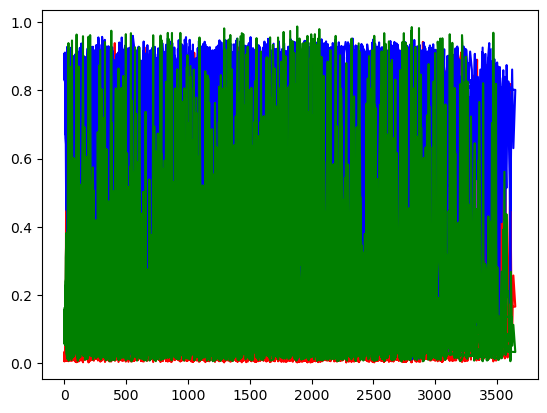

In [78]:
# graph the sentiment over time
plt.plot([t['xmin'] for t in tgs], [t['negative'] for t in tgs], color='red')
plt.plot([t['xmin'] for t in tgs], [t['neutral'] for t in tgs], color='blue')
plt.plot([t['xmin'] for t in tgs], [t['positive'] for t in tgs], color='green')